# Minimal HO calving model with artificial geometry

Implementation of a simple calving law. Assuming some idealized bed, initial geometry, and surface mass balance, we experiment with a calving parameterization similar to [Oerlemans and Nick, 2005](https://www.cambridge.org/core/journals/annals-of-glaciology/article/minimal-model-of-a-tidewater-glacier/C6B72F547D8C44CDAAAD337E1F2FC97F), in which the calving flux, in cubic meters per year, is given as 

$$ F_c = cdH_tw_t $$

where $d$ is water depth, $H_t$ is terminus thickness, $w_t$ is the terminus width, and $c$ is a tuning parameter whose units are a$^{-1}$. We modify this to a calving rate $u_c$ by dividing out the width dimension, and normalizing via:

$$u_c = c_1\sqrt{dH_t}.$$

We begine by specifying a given lake level, with water depth the difference between that level and the bed. At each timestep, we assume the glacier incrementally moves forward in accordance with its terminal velocity, and that it moves backward (if applicable) in accordance with the calving rate specified above. In order to test the ability of our model to also capture advance, we add an element of randomness to calving behaviour, expressing the likelihood of calving, in a given timestep, as:

$$p_{calving} = c_2\Delta t f_{af}$$

where $f_{af}$ is the fraction above flotation at the terminus (and if this value becomes negative, a calving event is imposed). If this probability criterion is not met in a given step, "calving pressure" accumulates, so that the next calving event is larger. Thus, calving events become smaller and more frequent as the terminus retreats from deep water, mimicking a transition to serac collapse of a well-grounded glacier. Meanwhile, the coarser the time resolution, the more likely a calving event is to occur in a given timestep. 

In [1]:
c_1, c_2 = -1.0, 10 #calving parameters

## Imports

In [2]:
from firedrake import *
import icepack
from icepack.models.hybrid import horizontal_strain_rate, vertical_strain_rate, _effective_strain_rate
import matplotlib.pyplot as plt
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
import numpy as np
import os
import tqdm

os.chdir('/eejit/home/bezu0001/icepack/notebooks/GLIMMER/1D_modelling')
from centerflow_extruded import *

## Paths

In [3]:
figures_path = '/eejit/home/bezu0001/icepack/figures/HO_calving_artificial/'

## Mesh with centerline_extruded

In [4]:
n_cells = 200
length = 10000

mesh = centerline_mesh(n_cells = n_cells, length = length)
x, z = SpatialCoordinate(mesh.mesh)
V = FunctionSpace(mesh.mesh, 'CG', 1, vfamily = 'GL', vdegree = 2) #function space for quantities which vary with depth
Q = FunctionSpace(mesh.mesh, 'CG', 1, vfamily = 'R', vdegree = 0)

## Define initial geometry

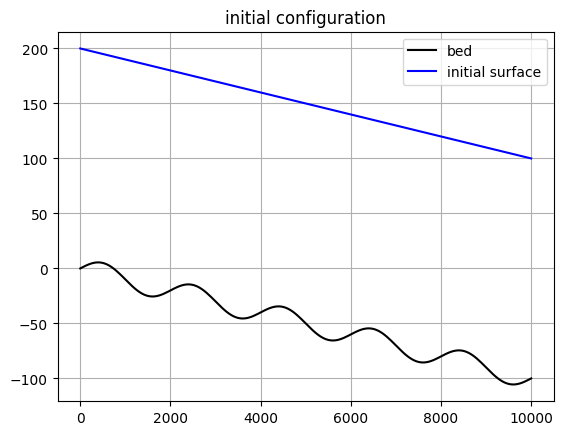

In [5]:
amp = 10.0      
period = mesh.length/5   
frontal_elevation = -100.0 #elevation of bed at the front (negative below sea level)
slope = -0.01 #underlying bed slope

offset = frontal_elevation - slope*mesh.length
bed_flat  = Function(Q).interpolate(offset + slope*x) #the bed slope downward
bed_bumpy = Function(Q).interpolate(amp*firedrake.sin(2*np.pi*x/period)) #with some sinusoidal variation superimposed
bed = Function(Q).interpolate(bed_flat + bed_bumpy)

H_0 = Constant(200)
H = Function(Q).project(H_0)
s = Function(Q).project(bed_flat + H_0)
u = Function(V).project(Function(Q).project(Constant(1e-10)))
smb = Constant(0)

plt.figure()
plt.title('initial configuration')
plt.plot(mesh.X, icepack.depth_average(bed).at(mesh.X), color = 'k', label = 'bed')
plt.plot(mesh.X, icepack.depth_average(s).at(mesh.X), color = 'blue', label = 'initial surface')
# plt.ylim(-length/2, length/2)
plt.legend()
plt.grid()

## Initialize solvers

In [6]:
def basal_friction(**kwargs): #function to scale the basal friction by fraction above flotation
    H = kwargs['thickness']
    s = kwargs['surface']
    u = kwargs['velocity']
    C = kwargs['friction']

    b = s - H
    ϱ = icepack.constants.ice_density/icepack.constants.water_density 

    flotation_surface = (1 - ϱ)*H #given the current thickness, this is the hypothetical surface elevation which would float the shelf
    h_af = s - flotation_surface #height above flotation
    frac_af = firedrake.min_value(h_af/H, 1) #fraction above flotation, capped at unity
    
    return icepack.models.hybrid.bed_friction(velocity = u, friction = C*frac_af)

T = 273.15 - 0 #ice temperature (K), assumed isothermal
A = Constant(icepack.rate_factor(T))
C = Constant(0.5)

model_opts = {'dirichlet_ids': [1]}
flow_model = icepack.models.HybridModel(friction = basal_friction)
flow_solver = icepack.solvers.FlowSolver(flow_model, **model_opts)

## Spin up to steady state

In [7]:
model_time = 200
Δt = 1/10
num_timesteps = int(model_time/Δt)

for step in trange(num_timesteps):
    u = flow_solver.diagnostic_solve(velocity = u, thickness = H, surface = s, fluidity = A, friction = C)
    H = flow_solver.prognostic_solve(Δt, thickness = H, velocity = u, thickness_inflow = H_0, accumulation = smb)
    s = icepack.compute_surface(thickness = H, bed = bed)

base = Function(Q).project(s - H)

u_surf_array = u.at(mesh.surface_coords, tolerance = 1e-10)
u_base_array = u.at(mesh.basal_coords, tolerance = 1e-10)
s_array = icepack.depth_average(s).at(mesh.X, tolerance = 1e-10)
bed_array = icepack.depth_average(bed).at(mesh.X, tolerance = 1e-10)
base_array = icepack.depth_average(base).at(mesh.X, tolerance = 1e-10)

100%|██████████| 2000/2000 [01:06<00:00, 29.92it/s]


In [8]:
ϱ = icepack.constants.ice_density/icepack.constants.water_density

H_0 = Constant(H.at(0, 0))
bed_t = icepack.depth_average(bed).at(mesh.length, tolerance = 1e-10)
x_t = mesh.length

Δx = mesh.length/4 #extend the domain to permit advance
mesh_0 = centerline_mesh(mesh = mesh, n_cells = n_cells, extra_length = Δx)
mesh_1 = mesh
bed_0 = extend_to_mesh(function = bed, mesh = mesh_0, ice_free_value = bed_t)

Q = bed.function_space()
bed0_array = np.array(icepack.depth_average(bed_0).at(mesh_0.X, tolerance = 1e-10))
d = Function(Q).project(max_value(-base, 0))
print(f'initial water depth = {d.at(x_t, 0)} m')

Δxs = []
fafs = []

x_1, x_2 = mesh_0.length - mesh_0.length, mesh_0.length
y_1 = bed_0.at((x_2, 0), tolerance = 1e-10) - 100
y_2 = s.at((x_1, 0), tolerance = 1e-10) + 100

initial water depth = 71.67270994946492 m


Text(0.5, 1.0, 'steady state geometry')

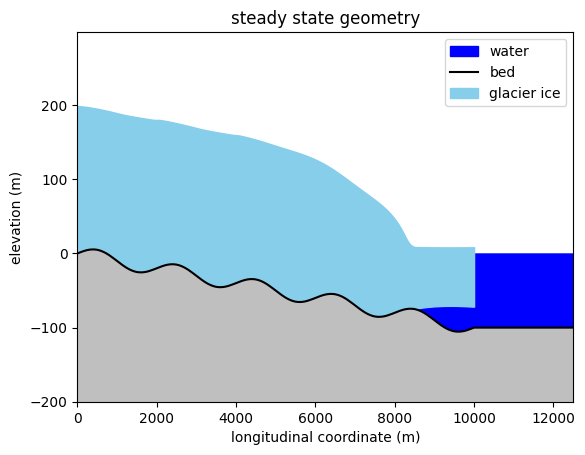

In [9]:
s_array = np.array(icepack.depth_average(s).at(mesh_1.X, tolerance = 1e-10))
base_array = np.array(icepack.depth_average(base).at(mesh_1.X, tolerance = 1e-10))

water_mask = (0 > bed0_array) # & (mesh_0.X > x_t)

plt.figure()
plt.fill_between(mesh_0.X, bed0_array, 0, color = 'blue', where = water_mask, label = 'water')
plt.plot(mesh_0.X, bed0_array, color = 'k', label = 'bed')
plt.fill_between(mesh_1.X, base_array, s_array, color = 'skyblue', label = 'glacier ice')
plt.fill_between(mesh_0.X, y_1, bed0_array, color = '0.75')
plt.legend(loc = 'upper right')
plt.xlabel('longitudinal coordinate (m)')
plt.ylabel('elevation (m)')
plt.xlim(x_1, x_2)
plt.ylim(y_1, y_2)
plt.title('steady state geometry')
# plt.grid()

## Run the calving model

100%|█████████▉| 999/1000 [43:13<00:02,  2.54s/it]

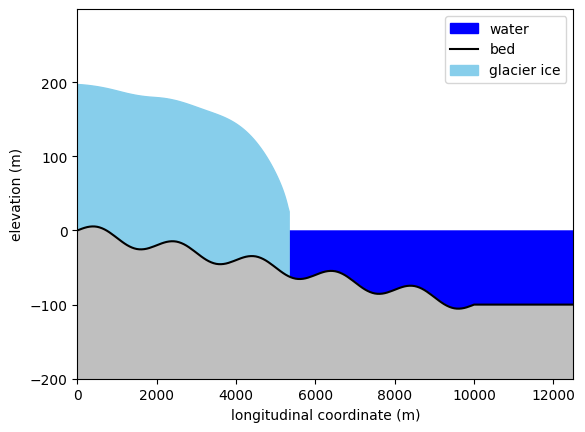

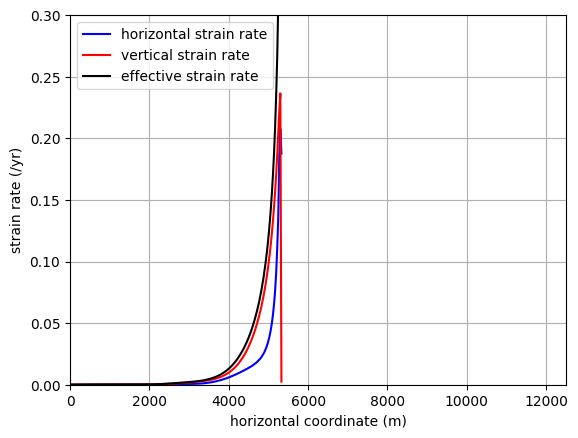

100%|██████████| 1000/1000 [43:16<00:00,  2.60s/it]


In [10]:
model_time = 100
num_timesteps = int(model_time/Δt)
calving_pressure = 0

for step in trange(num_timesteps):

    flow_model = icepack.models.HybridModel(friction = basal_friction)
    flow_solver = icepack.solvers.FlowSolver(flow_model, **model_opts)

    u = flow_solver.diagnostic_solve(velocity = u, thickness = H, surface = s, fluidity = A, friction = C)
    H = flow_solver.prognostic_solve(Δt, thickness = H, velocity = u, thickness_inflow = H_0, accumulation = smb)
    s = icepack.compute_surface(bed = bed, thickness = H)
    base = Function(Q).project(s - H)
    d = Function(Q).project(max_value(-base, 0))
    
    H_t = H.at(x_t, 0)
    d_t = d.at(x_t, 0)
    u_t = icepack.depth_average(u).at(x_t)
    advance = u_t*Δt
    
    f_af = max(ϱ*H_t/d_t - 1, 0.01) #fraction above flotation
    fafs.append(f_af)
    
    calving_pressure += c_1*np.sqrt(H_t*d_t)*Δt
    if np.random.random() > c_2*Δt*f_af and u_t*Δt + mesh_1.length < mesh_0.length:
        retreat = 0 #no calving
    else:
        retreat = calving_pressure #calve the appropriate length - including any previously suppressed calving
        calving_pressure = 0
    
    Δx = advance + retreat
    Δxs.append(Δx)
        
    mesh_2 = centerline_mesh(mesh = mesh_1, n_cells = n_cells, extra_length = Δx)
    x_t = mesh_2.length
    
    H = extend_to_mesh(function = H, mesh = mesh_2, ice_free_value = H_t)
    bed = extend_to_mesh(function = bed_0, mesh = mesh_2)
    s = icepack.compute_surface(bed = bed, thickness = H)
    u = extend_to_mesh(function = u, mesh = mesh_2, ice_free_value = u_t)

    Q = s.function_space()
    V = u.function_space()
    base = Function(Q).project(s - H)

    mesh_1 = mesh_2

    bed_array = np.array(icepack.depth_average(bed).at(mesh_1.X, tolerance = 1e-10))
    s_array = np.array(icepack.depth_average(s).at(mesh_1.X, tolerance = 1e-10))
    H_array = np.array(icepack.depth_average(H).at(mesh_1.X, tolerance = 1e-10))
    base_array = s_array - H_array
    water_mask = (0 > bed0_array) 
    
    plt.figure()
    plt.fill_between(mesh_0.X, bed0_array, 0, color = 'blue', where = water_mask, label = 'water')
    plt.plot(mesh_0.X, bed0_array, color = 'k', label = 'bed')
    plt.fill_between(mesh_1.X, base_array, s_array, color = 'skyblue', label = 'glacier ice')
    plt.fill_between(mesh_0.X, y_1, bed0_array, color = '0.75')
    plt.legend(loc = 'upper right')
    plt.xlabel('longitudinal coordinate (m)')
    plt.ylabel('elevation (m)')
    plt.xlim(x_1, x_2)
    plt.ylim(y_1, y_2)
    # plt.grid()
    os.chdir(figures_path + 'profiles')
    plt.savefig(f'profile_{step}') 
    if step < num_timesteps - 1:
        plt.close()
    else:
        plt.show()

    ε_xx = horizontal_strain_rate(velocity = u, thickness = H, surface = s)
    ε_xz = vertical_strain_rate(velocity = u, thickness = H)
    ε_e =_effective_strain_rate(ε_xx, ε_xz, icepack.constants.strain_rate_min)    
    εe_array = np.array(icepack.depth_average(Function(V).project(ε_e)).at(mesh_1.X, tolerance = 1e-10))
    εxx_array = np.array(icepack.depth_average(Function(V).project(ε_xx)).at(mesh_1.X, tolerance = 1e-10))
    εxz_array = np.array(icepack.depth_average(Function(V).project(ε_xz)).at(mesh_1.X, tolerance = 1e-10))
    
    plt.figure()
    plt.plot(mesh_1.X, εxx_array, color = 'blue', label = 'horizontal strain rate')
    plt.plot(mesh_1.X, εxz_array, color = 'red', label = 'vertical strain rate')
    plt.plot(mesh_1.X, εe_array, color = 'k', label = 'effective strain rate')
    plt.xlabel('horizontal coordinate (m)')
    plt.ylabel('strain rate (/yr)')
    plt.ylim(0, 0.3) 
    plt.xlim(0, mesh_0.length)
    plt.grid()
    plt.legend(loc = 'upper left')
    os.chdir(figures_path + 'strain_rates')
    plt.savefig(f'strain_rate_{step}') 
    if step < num_timesteps - 1:
        plt.close()
    else:
        plt.show()

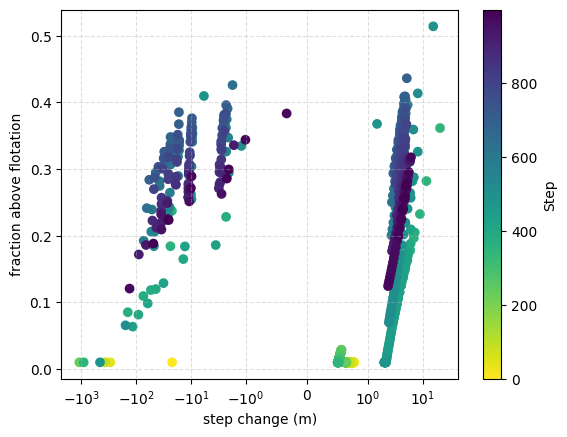

In [11]:
N = len(fafs)
steps = np.arange(N)
cmap = plt.get_cmap('viridis_r')
norm = Normalize(vmin=0, vmax=N-1)

fig, ax = plt.subplots()
sc = ax.scatter(Δxs, fafs, c=steps, cmap=cmap, norm=norm)

# Optional: symlog if you have negatives
ax.set_xscale('symlog', linthresh=1)
# ax.set_yscale('symlog', linthresh=1e-3)

ax.grid(True, which='both', ls='--', alpha=0.4)
ax.set_xlabel('step change (m)')
ax.set_ylabel('fraction above flotation')

fig.colorbar(sc, ax=ax, label='Step')   # <-- use sc, not a bare ScalarMappable
plt.show()